# Energy Dataset

The script below aims to apply various models for forecasting future values in a time series.

These models consist of Exponential Smoothing models, namely Simple Exponential Smoothing, Holt's Exponential Smoothing, Additive Holt-Winters Exponential Smoothing, and Multiplicative Holt-Winters Exponential Smoothing. Additionally, ARIMA models will be used, with the best model selected using the 'auto_arima' function.

The accuracy of the models will be assessed using MAPE (Mean Absolute Percentage Error), a widely utilized metric for evaluating the forecast accuracy in time series. The more accurate models will be plotted alongside the actual values, allowing for a visual analysis of the results.

## Dataset Description

The time series under analysis is the energy consumption in a region of Brazil, with data available from 1979 to the year 2020. The data prior to 2017 will be used for training, while the remaining data will be used to test the predictions made.

## Implementation

- Check the Dataset


- Create and Adjust the Exponential Smoothing Models


- Create and Adjust the best ARIMA Model


- Predict the values based on the models
***

## Checking Dataset

In [27]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs
import warnings

warnings.filterwarnings("ignore")
sns.set()

In [28]:
# Checking Dataset
df_energy = pd.read_csv(f"Data/consumo_energia.csv", index_col=0)
df_energy.head(10)

,Data,Consumo
0,1979.01,5623
1,1979.02,5551
2,1979.03,5725
3,1979.04,5797
4,1979.05,6002
5,1979.06,5988
6,1979.07,6054
7,1979.08,6022
8,1979.09,6353
9,1979.10,6144


In [29]:
# Transforming the Date column with string operations
df_energy['Data'] = df_energy['Data'].astype(str).str.replace('.', '-')
df_energy['Data'].head(12)

0     1979-01
1     1979-02
2     1979-03
3     1979-04
4     1979-05
5     1979-06
6     1979-07
7     1979-08
8     1979-09
9      1979-1
10    1979-11
11    1979-12
Name: Data, dtype: object

In [30]:
# Transforming the Date column with string operations
df_energy['Data'].loc[df_energy['Data'].str.endswith('-1')] = df_energy['Data'].loc[df_energy['Data'].str.endswith('-1')].str.replace('-1', '-10')
df_energy['Data'].head(12)

0     1979-01
1     1979-02
2     1979-03
3     1979-04
4     1979-05
5     1979-06
6     1979-07
7     1979-08
8     1979-09
9     1979-10
10    1979-11
11    1979-12
Name: Data, dtype: object

In [31]:
# Transforming the Date column type
df_energy['Data'] = pd.to_datetime(df_energy['Data'] + '-01')

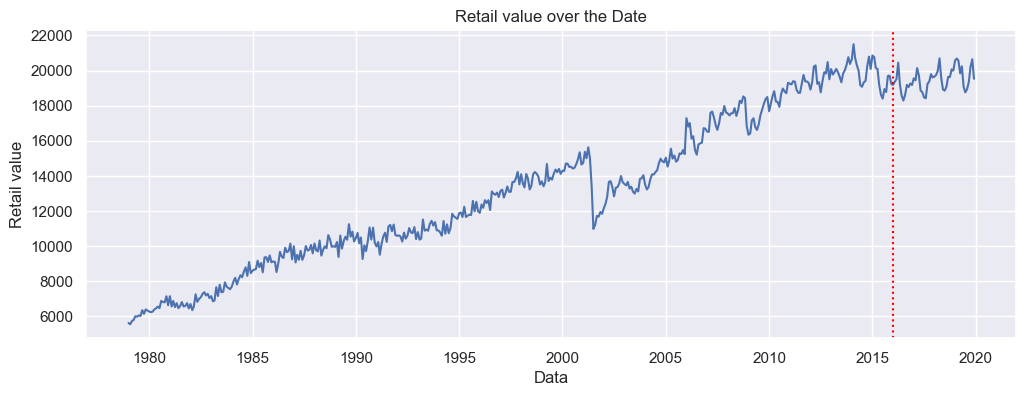

In [32]:
# Plotting the Retail Value over the Date
plt.figure(figsize=(12,4))
plt.plot(df_energy['Data'], df_energy['Consumo'])
plt.xlabel('Data')
plt.ylabel('Retail value')
plt.title('Retail value over the Date')
plt.axvline(dt.datetime(2016, 1, 1), color='red', linestyle='dotted')
plt.show();

In [33]:
# Decomposing the time series
decomposed_ts = sm.tsa.seasonal_decompose(df_energy['Consumo'], period=12)

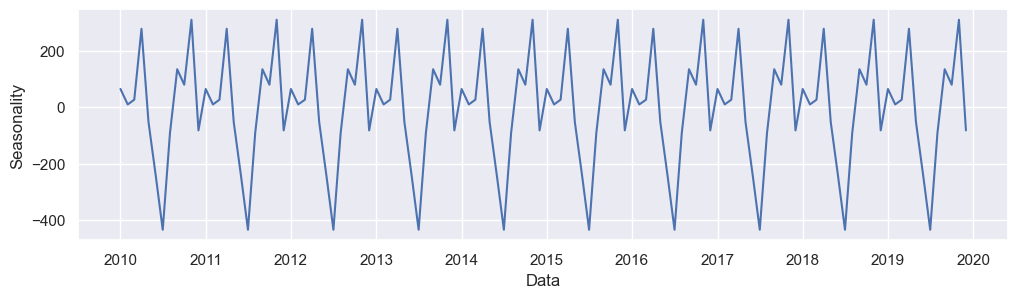

In [34]:
# Plotting the Seasonality
plt.figure(figsize=(12,3))
plt.plot(df_energy['Data'][len(df_energy)-120:], decomposed_ts.seasonal[len(df_energy)-120:])
plt.xlabel('Data')
plt.ylabel('Seasonality')
plt.show();

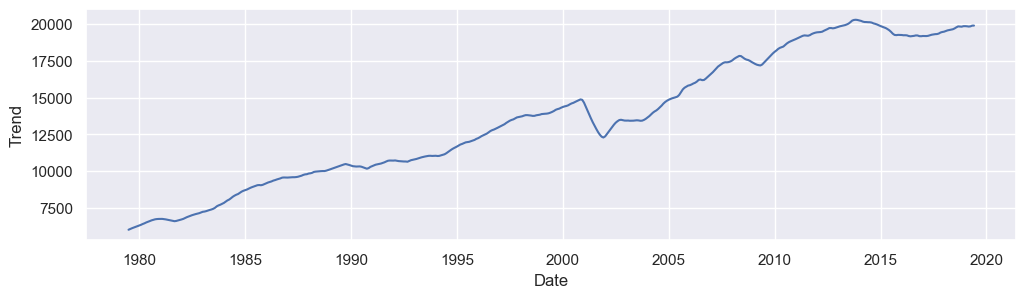

In [35]:
# Plotting the Trend
plt.figure(figsize=(12,3))
plt.plot(df_energy['Data'], decomposed_ts.trend)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.show();



## Creating and Adjusting Exponential Smoothing Models


From the charts, it is quite clear to observe the annual seasonal behavior, in addition to the upward trend. So the Holt-Winters model will probably get the best predictions.

In [36]:
# Splitting the dataset on train and test
split_index = df_energy.loc[df_energy['Data']==dt.datetime(2016,1,1)].index[0]
df_train = df_energy['Consumo'].loc[:split_index]
df_test = df_energy['Consumo'].loc[split_index+1:]

In [37]:
# SES Model
model_ses = sm.tsa.SimpleExpSmoothing(df_train, initialization_method='estimated')
model_ses = model_ses.fit()
model_ses.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,SimpleExpSmoothing,SSE,89063186.122
Optimized:,True,AIC,5436.018
Trend:,None,BIC,5444.214
Seasonal:,None,AICC,5436.109
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:57:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7290522,alpha,True
initial_level,5618.9227,l.0,True


In [38]:
# Holt Linear Model
model_holt = Holt(df_train, damped_trend=False, initialization_method='estimated')
model_holt = model_holt.fit()
model_holt.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,Holt,SSE,89885478.917
Optimized:,True,AIC,5444.108
Trend:,Additive,BIC,5460.500
Seasonal:,None,AICC,5444.300
Seasonal Periods:,None,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:57:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7121429,alpha,True
smoothing_trend,0.0197817,beta,True


In [39]:
# Model Holt Winter (Additive)
model_hw_add = ExponentialSmoothing(df_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
model_hw_add = model_hw_add.fit()
model_hw_add.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,ExponentialSmoothing,SSE,72258749.956
Optimized:,True,AIC,5370.972
Trend:,Additive,BIC,5436.541
Seasonal:,Additive,AICC,5372.578
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:57:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7124307,alpha,True
smoothing_trend,9.9965e-05,beta,True


In [40]:
# Model Holt Winter (Multiplicative)
model_hw_mul = ExponentialSmoothing(df_train, trend='mul', seasonal='mul', seasonal_periods=12, initialization_method='heuristic')
model_hw_mul = model_hw_mul.fit()
model_hw_mul.summary()

Dep. Variable:,Consumo,No. Observations:,445
Model:,ExponentialSmoothing,SSE,77369077.298
Optimized:,True,AIC,5401.380
Trend:,Multiplicative,BIC,5466.950
Seasonal:,Multiplicative,AICC,5402.986
Seasonal Periods:,12,Date:,"Tue, 06 Jun 2023"
Box-Cox:,False,Time:,15:57:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6414286,alpha,True
smoothing_trend,0.0278882,beta,True


## Creating and Adjusting ARIMA Model

In [41]:
# Dickey Fuller Test
adf_result = adfuller(df_energy['Consumo'], maxlag=1)
adf_result

(-1.3015458142577163,
 0.6284648053601171,
 1,
 490,
 {'1%': -3.4437660979098843,
  '5%': -2.8674565460819896,
  '10%': -2.569921291128696},
 7400.58529251654)

The series is not stationary, and usually, it would be necessary to perform differencing on the series. However, the algorithm used will automatically handle this process (thus, the corresponding 'I' of ARIMA will be different from 0).

In [42]:
# Creating the ARIMA model
arima_model = auto_arima(df_energy['Consumo'].loc[df_train.index], trace=True, seazonal=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6714.076, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6621.943, Time=0.40 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6632.555, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6714.007, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6683.852, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=6621.876, Time=0.69 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.44 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6594.475, Time=0.80 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6632.144, Time=0.25 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=inf, Time=1.77 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=6628.234, Time=0.56 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=6588.819, Time=1.96 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(2,1,0)(2,0,2)[12] intercept   : 

In [43]:
# Fitting
arima_model.fit(df_energy['Consumo'].loc[df_train.index])

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [44]:
# Model Outputs
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  445
Model:             SARIMAX(1, 1, 0)x(2, 0, [1, 2], 12)   Log Likelihood               -3287.410
Date:                                 Tue, 06 Jun 2023   AIC                           6588.819
Time:                                         15:57:59   BIC                           6617.490
Sample:                                              0   HQIC                          6600.126
                                                 - 445                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4796      3.160      0.152      0.879      -5.714       6.673
ar.L1         -0.2616      0.043     -6.071      0.000      -0.346      -0.177
ar.S.L12       0.4948      0.221      2.237      0.025       0.061       0.928
ar.S.L24       0.4692      0.220      2.128      0.033       0.037       0.901
ma.S.L12      -0.2555      0.198     -1.289      0.197      -0.644       0.133
ma.S.L24      -0.5572      0.185     -3.005      0.003      -0.921      -0.194
sigma2      1.694e+05   8692.119     19.486      0.000    1.52e+05    1.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               919.97
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Checking Predictions and the Model's MAPE

In [45]:
# Creating a function to calculate the MAPE
def mape(serie):
    print(np.mean(abs((df_test-serie)/df_test))*100)
    return

In [46]:
# Getting SES predictions
ses_predictions = model_ses.forecast(steps=len(df_test))
# Getting HOLT predictions
holt_predictions = model_holt.forecast(steps=len(df_test))
# Getting HW Add predictions
hw_add_predictions = model_hw_add.forecast(steps=len(df_test))
# Getting HW Multiplicative predictions
hw_mul_predictions = model_hw_mul.forecast(steps=len(df_test))
# Getting Arima predictions
arima_predictions = arima_model.predict(n_periods=len(df_test))

In [47]:
# SES MAPE
mape(ses_predictions)

2.790481154707416


In [48]:
# Holt Linear MAPE
mape(holt_predictions)

2.502721742667035


In [49]:
# Holt-Winters (additive) MAPE
mape(hw_add_predictions)

2.784080238958958


In [50]:
# Holt-Winters (multiplicative) MAPE
mape(hw_mul_predictions)

3.4988268863908782


In [51]:
# ARIMA MAPE
mape(arima_predictions)

1.7754438587378136


## Conclusions

The MAPE of the ARIMA model was the lowest, indicating that this model performed the best in predicting new values. The second-best model was Holt-Linear, while additive HW and SES had practically the same values. On the other hand, multiplicative HW performed the worst in predictions.

The predicted values will be plotted along with the actual values in the graph below.

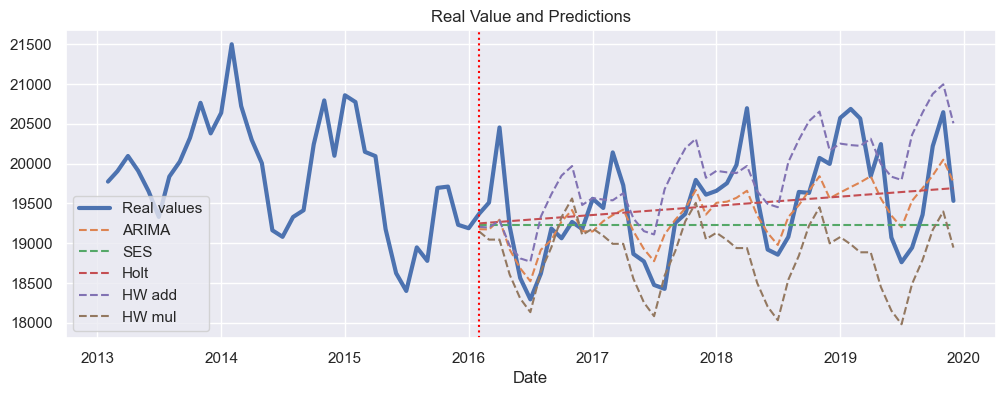

In [52]:
# Plotting the Retail Value and predictions after 2020
plt.figure(figsize=(12,4))
plt.plot(df_energy['Data'].loc[df_energy['Data']>dt.datetime(2013, 1, 1)], df_energy['Consumo'].loc[df_energy['Data']>dt.datetime(2013, 1, 1)], lw=3)
plt.plot(df_energy['Data'].loc[df_test.index], arima_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], ses_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], holt_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], hw_add_predictions, linestyle='dashed')
plt.plot(df_energy['Data'].loc[df_test.index], hw_mul_predictions, linestyle='dashed')
plt.legend(['Real values', 'ARIMA', 'SES', 'Holt', 'HW add', 'HW mul'])
plt.xlabel('Date')
plt.title('Real Value and Predictions')
plt.axvline(dt.datetime(2016, 2, 1), color='red', linestyle='dotted')
plt.show();